<a href="https://colab.research.google.com/github/Hanzela634/Prediction-of-Lungs-Cancer/blob/main/Lungs_cancer_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Import Data**

In [ ]:
%config Completer.use_jedi = False
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import seaborn as sns
import cv2
import random
import os
import imageio
import plotly.graph_objects as go
import plotly.express as px
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
from collections import Counter
from sklearn.model_selection import train_test_split
import tensorflow as tf
from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Activation, BatchNormalization, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense, Dropout, LSTM, GRU
from keras.optimizers import Adam
from keras.models import Model
from keras.layers import Input, Dense, Flatten, Reshape

In [ ]:
directory = r'/content/drive/MyDrive/The IQ-OTHNCCD lung cancer dataset 2'

categories = ['Bengin cases', 'Malignant cases', 'Normal cases']

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Image Size Variations**

In [ ]:
# Initialize a dictionary to store size data for each category
size_data = {}
# Iterate over each category
for category in categories:
    category_path = os.path.join(directory, category)
# Skip if the category directory does not exist
    if not os.path.isdir(category_path):
        print(f"Directory not found: {category_path}")
        continue
# Initialize a dictionary to count image sizes
    size_count = {}
 # Process each file in the category directory
    for file_name in os.listdir(category_path):
        file_path = os.path.join(category_path, file_name)
# Skip if it's not a file or if reading the image fails
        if not os.path.isfile(file_path):
            continue
            try:
            image = imageio.imread(file_path)
            height, width, _ = image.shape
            size_key = f"{height}x{width}"
            # Update the size count
            size_count[size_key] = size_count.get(size_key, 0) + 1
        except Exception as e:
            print(f"Error reading file {file_path}: {e}")
            # Save the size count data for the current category
    size_data[category] = size_count
    # Output the size data
print(size_data)

<ipython-input-4-500afafd143c>:25: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(file_path)


{'Bengin cases': {'512x512': 120}, 'Malignant cases': {'512x512': 501, '512x623': 31, '512x801': 28, '404x511': 1}, 'Normal cases': {'512x512': 415, '331x506': 1}}


Category: Bengin cases


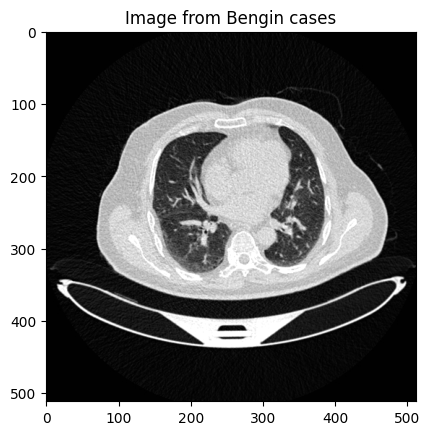

Category: Malignant cases


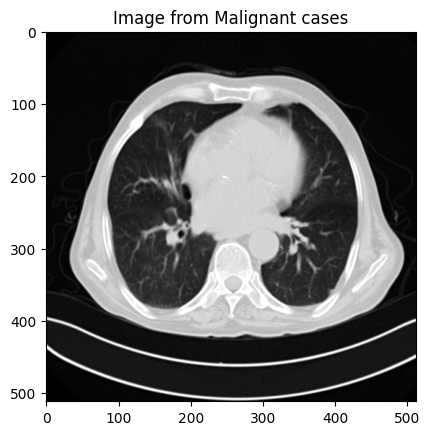

Category: Normal cases


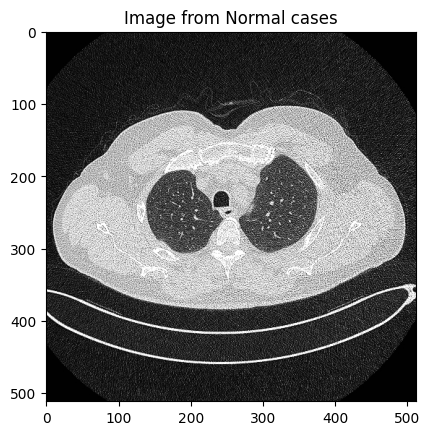

In [ ]:
# Iterate over each category
for category in categories:
    # Construct the path to the directory for the current category
    category_directory = os.path.join(directory, category)
    # Ensure the directory exists
    if not os.path.isdir(category_directory):
        print(f"Directory not found: {category_directory}")
        continue
        # Iterate over files in the category directory
    for file_name in os.listdir(category_directory):
        # Construct the full file path
        file_path = os.path.join(category_directory, file_name)
        # Print the current category
        print(f"Category: {category}")
        # Read and display the image in grayscale
        try:
            image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
            if image is not None:
                plt.imshow(image, cmap='gray')
                plt.title(f"Image from {category}")
                plt.show()
                break  # Exit after displaying the first image
            else:
                print(f"Failed to load image: {file_path}")
        except Exception as e:
            print(f"Error processing file {file_path}: {e}")

**Image Preprocessing and Testing**

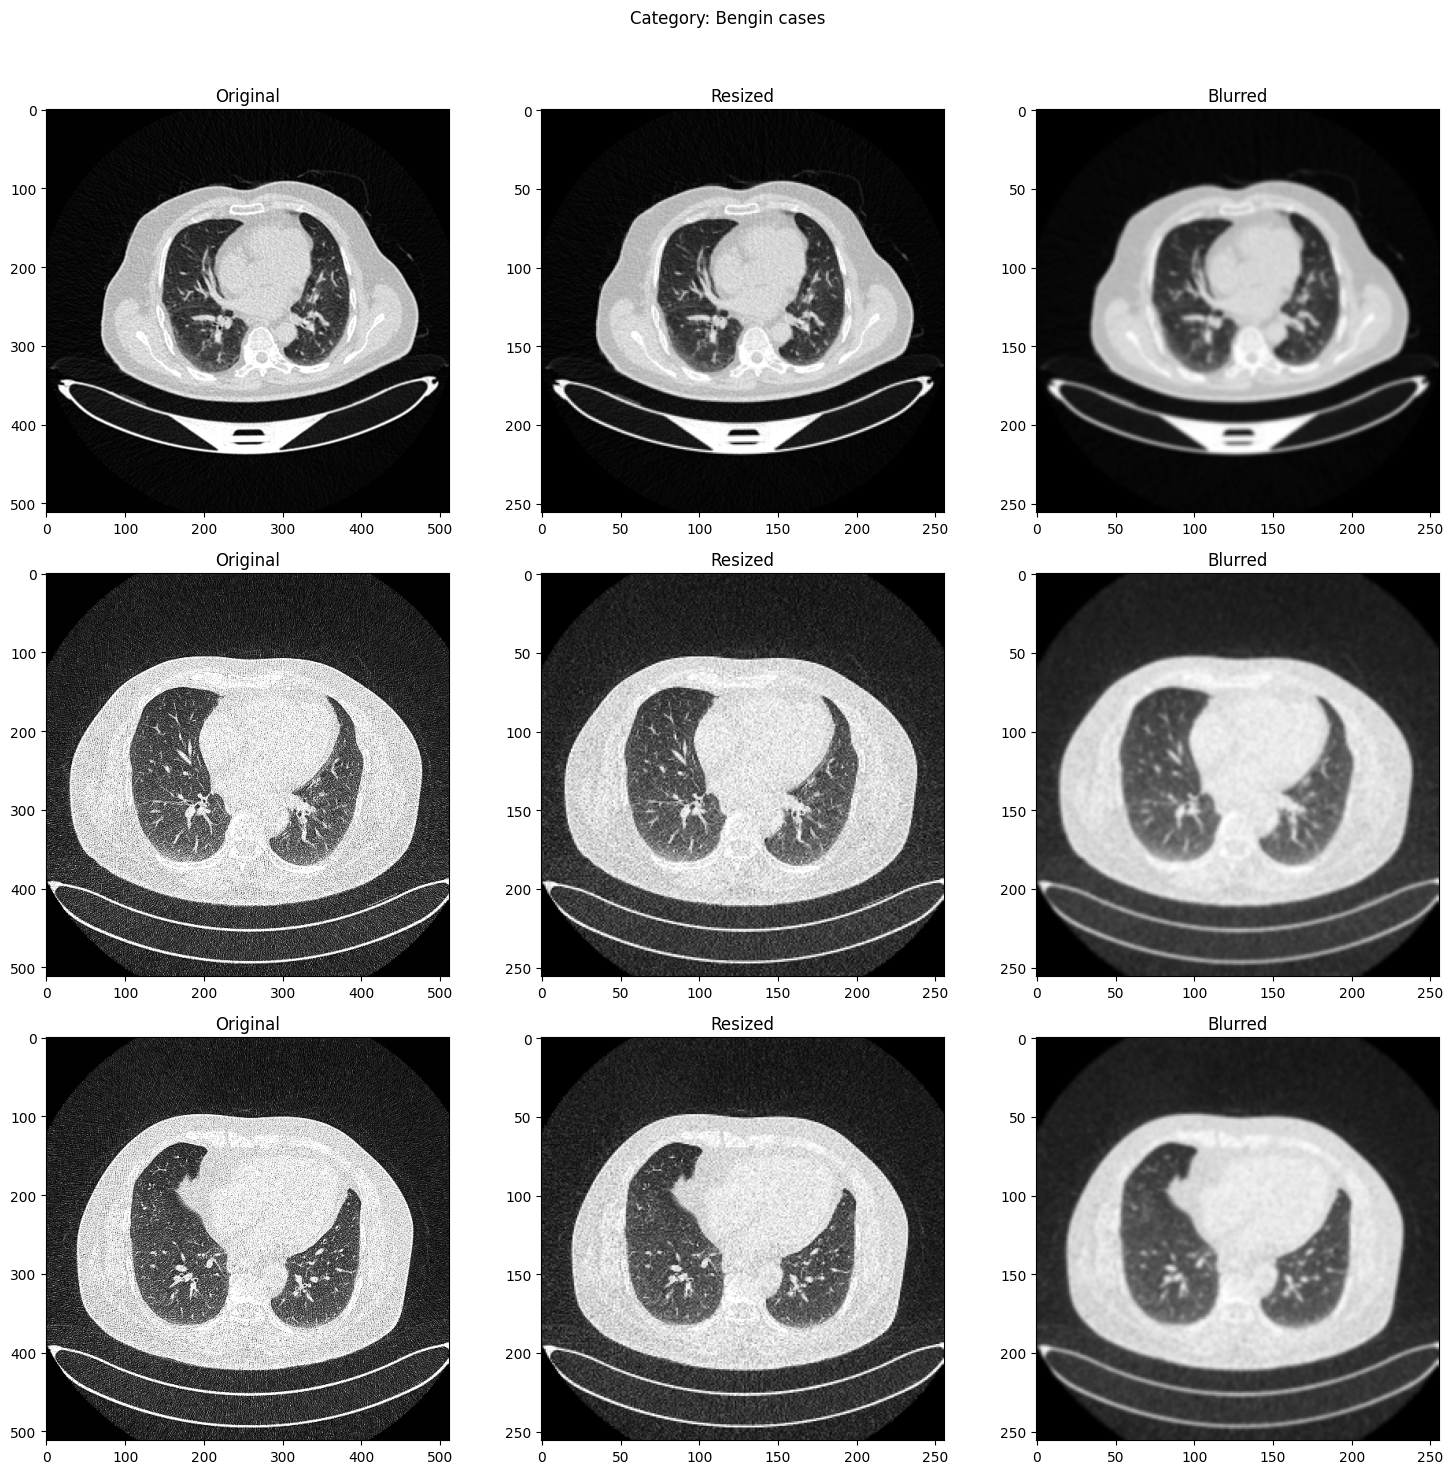

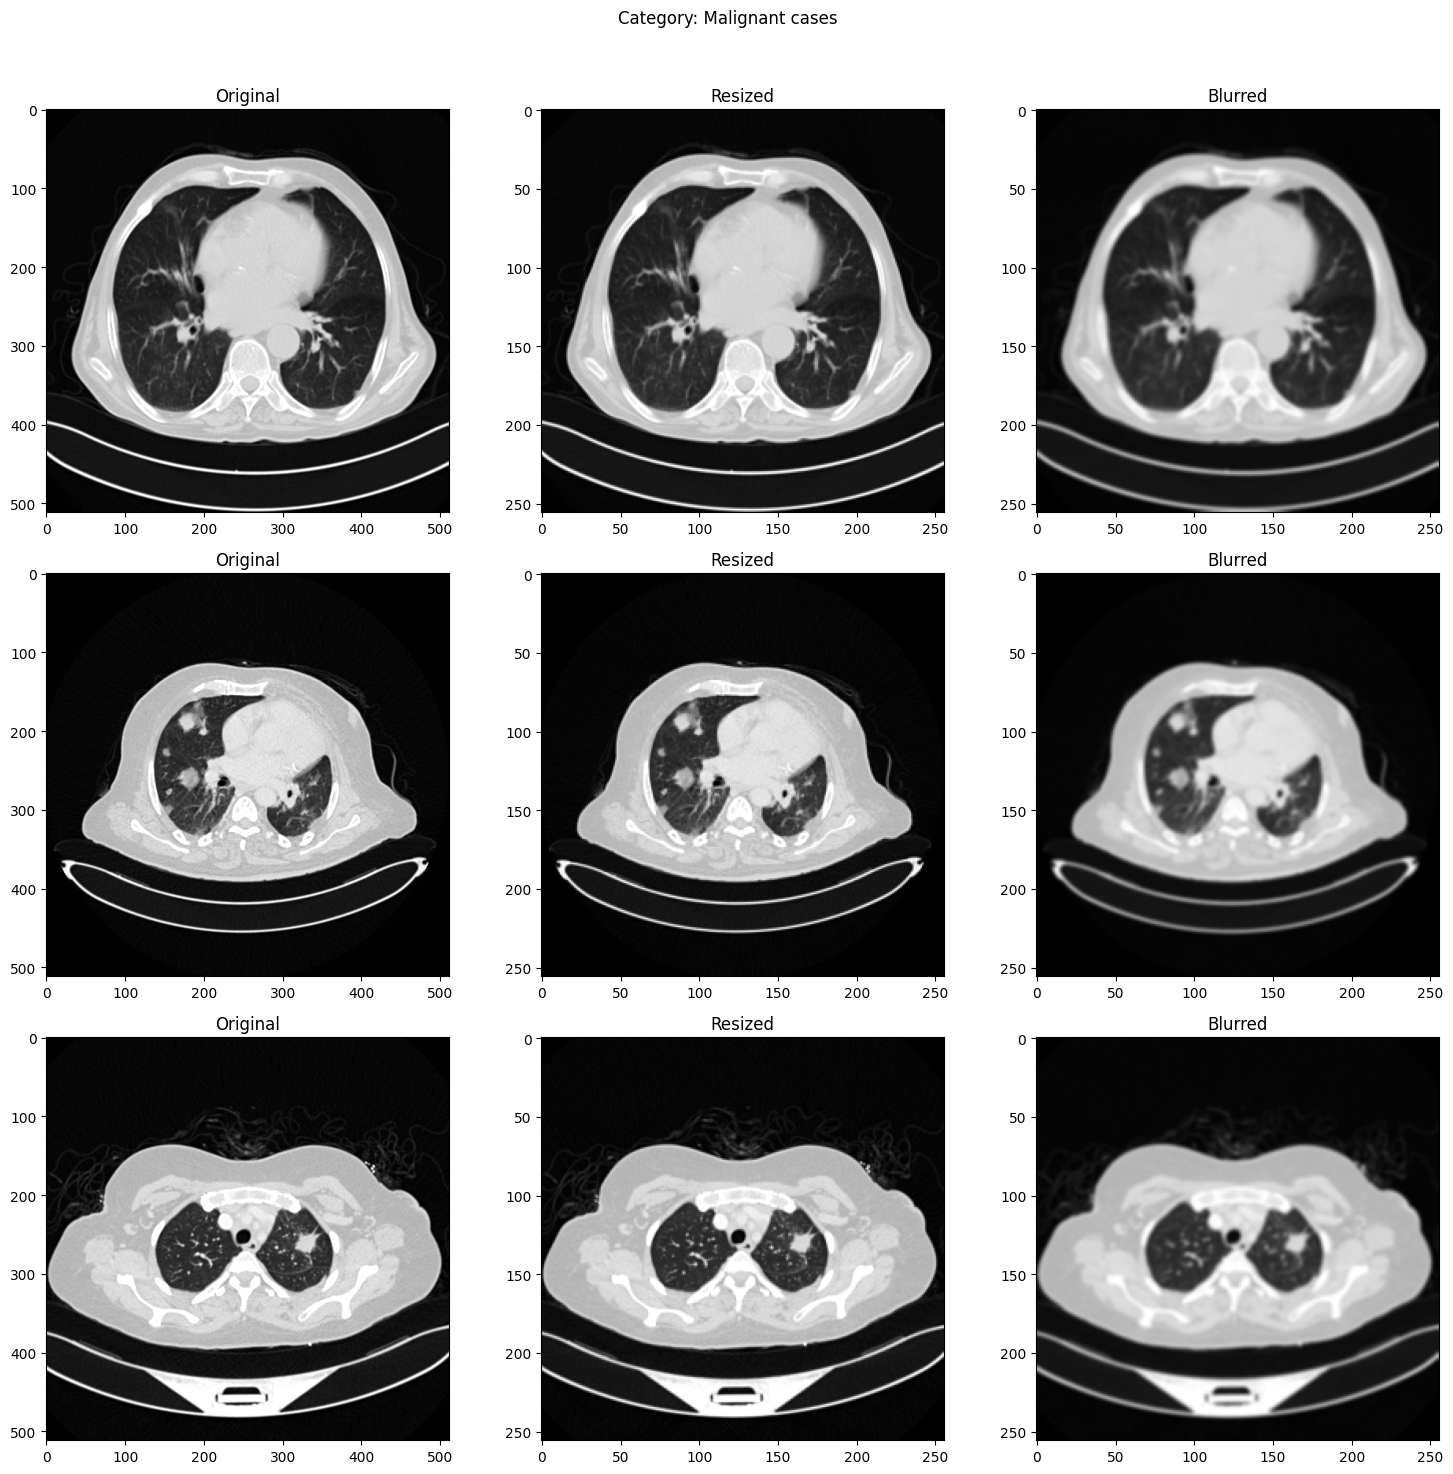

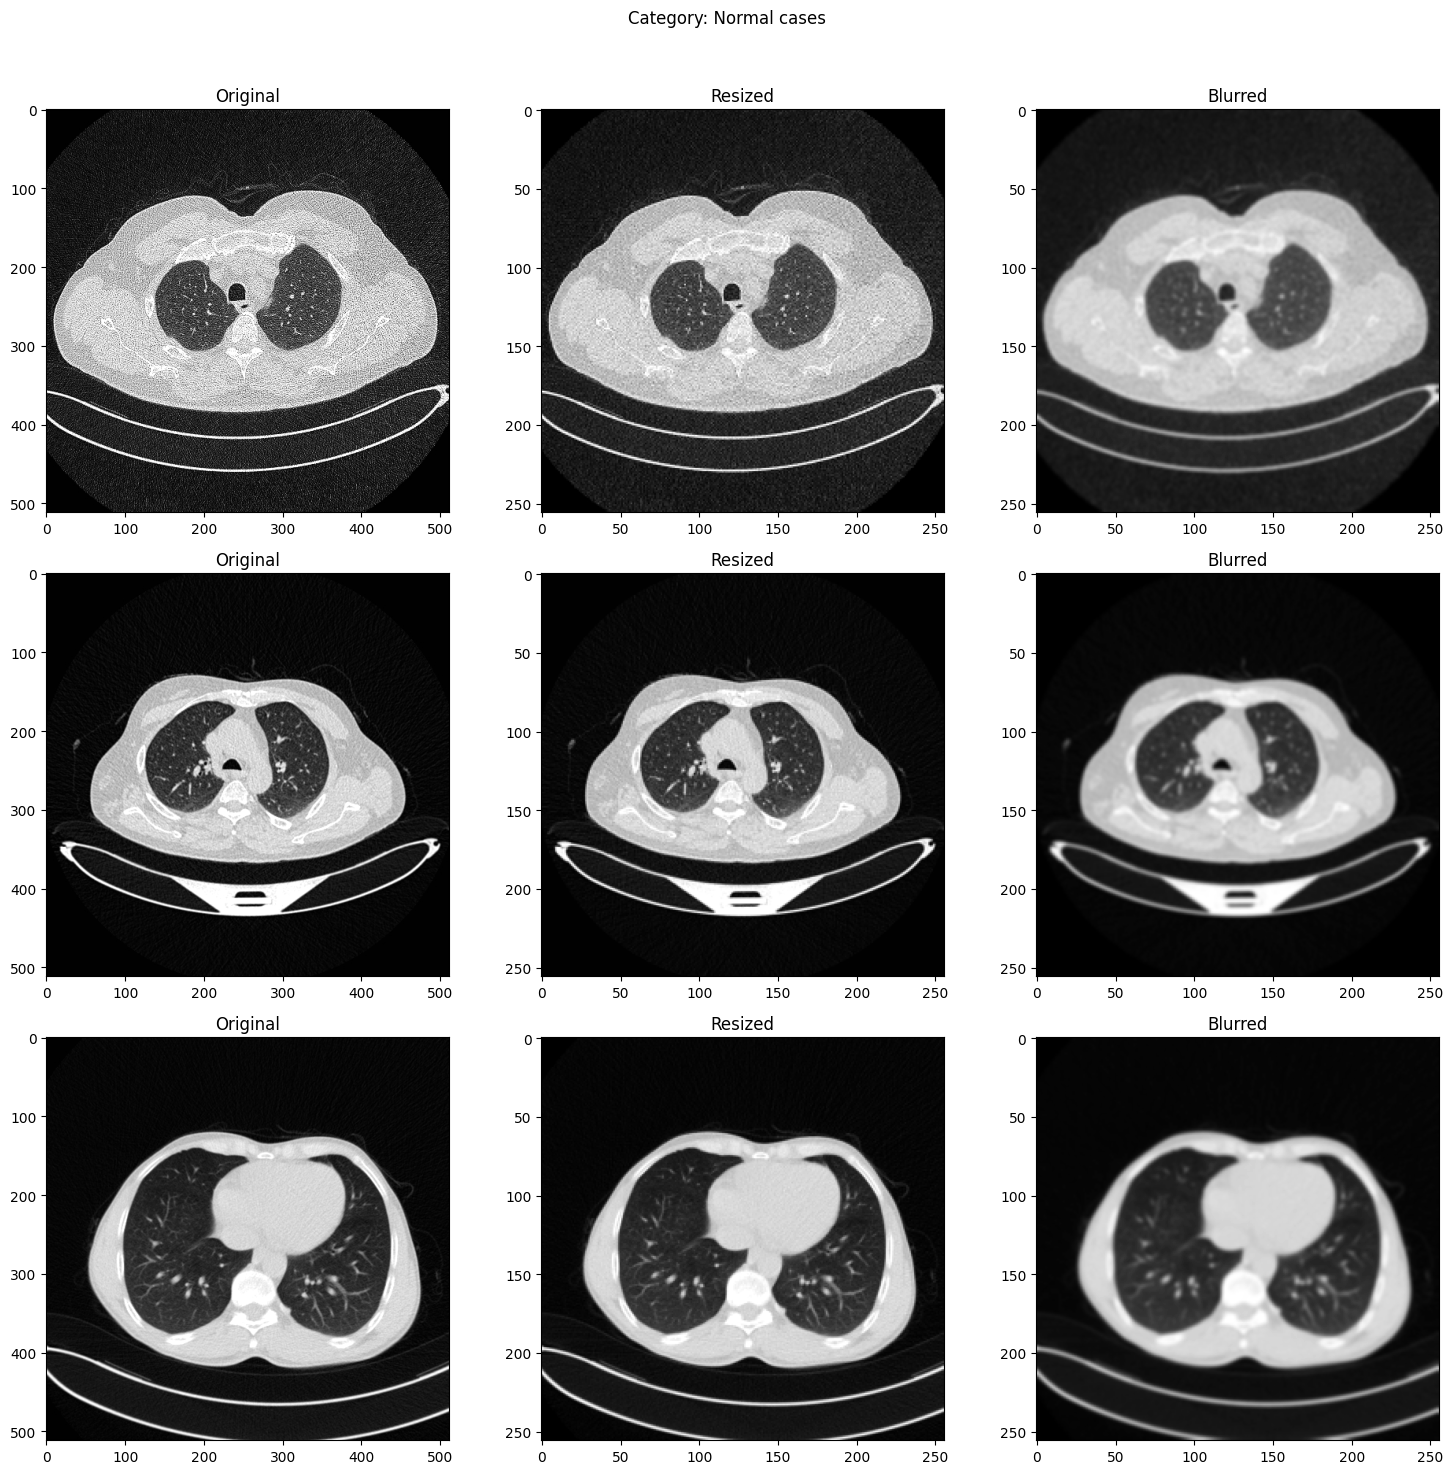

In [ ]:
# Define the size for resizing images
resize_dim = 256
# Iterate over each category in the dataset
for category_name in categories:
# Initialize counters and figure for plotting
sample_index, max_samples = 0, 3
    fig, axes = plt.subplots(max_samples, 3, figsize=(15, 15))
    fig.suptitle(f"Category: {category_name}")
    # Path to the current category directory
    category_folder = os.path.join(directory, category_name)
    # Iterate over files in the current category directory
    for file_index, image_file in enumerate(os.listdir(category_folder)):
        # Full path to the current image file
        image_path = os.path.join(category_folder, image_file)
        # Read the image in grayscale
        original_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        # Resize the image to the specified dimensions
        resized_image = cv2.resize(original_image, (resize_dim, resize_dim))
        # Apply Gaussian blur to the resized image
        blurred_image = cv2.GaussianBlur(resized_image, (5, 5), 0)
        # Display images in the subplot
        axes[sample_index, 0].imshow(original_image, cmap='gray')
        axes[sample_index, 0].set_title('Original')
        axes[sample_index, 1].imshow(resized_image, cmap='gray')
        axes[sample_index, 1].set_title('Resized')
        axes[sample_index, 2].imshow(blurred_image, cmap='gray')
        axes[sample_index, 2].set_title('Blurred')
        # Increment the sample index and exit loop if required number of samples is reached
        sample_index += 1
        if sample_index >= max_samples:
            break
            # Adjust layout and display the plots
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

**Preparing Data**

In [ ]:
# List to store image data and labels
dataset = []
   # Define the target size for resizing images
image_size = 256
  # Iterate over each category in the dataset
for category_name in categories:
  # Construct the path to the current category's directory
    category_folder = os.path.join(directory, category_name)
    # Assign a numeric label based on the category's index
    category_label = categories.index(category_name)
    # Process each image file in the category directory
    for file_name in os.listdir(category_folder):
      # Construct the full path to the image file
        image_path = os.path.join(category_folder, file_name)
        # Read the image in grayscale
        grayscale_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        # Preprocess the image: resize to target dimensions
        resized_image = cv2.resize(grayscale_image, (image_size, image_size))
        # Append the processed image and its label to the dataset
        dataset.append([resized_image, category_label])
        # Shuffle the dataset to mix up the order of images and labels
random.shuffle(dataset)
# Separate the images and labels into distinct lists
features, labels = [], []
for img, lbl in dataset:
    features.append(img)
    labels.append(lbl)
    # Print the number of images and distribution of labels
print('Number of images:', len(features))
print('Label distribution:', Counter(labels))
# Normalize the image data
features_array = np.array(features).reshape(-1, image_size, image_size, 1)
features_array = features_array / 255.0
labels_array = np.array(labels)

Number of images: 1097
Label distribution: Counter({1: 561, 2: 416, 0: 120})


In [ ]:
# Convert lists to NumPy arrays for compatibility with scikit-learn
X_array = np.array(features_array)
y_array = np.array(labels_array)
# Split the data into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(
    X_array, y_array, test_size=0.2, random_state=10, stratify=y_array)
# Print the sizes and shapes of the training and validation sets
print(f'Training set size: {len(X_train)}, Shape: {X_train.shape}')
print(f'Validation set size: {len(X_valid)}, Shape: {X_valid.shape}')

Training set size: 877, Shape: (877, 256, 256, 1)
Validation set size: 220, Shape: (220, 256, 256, 1)


**Applying SMOTE to oversample the data**

In [ ]:
# Flatten the training data for SMOTE application
n_samples, img_size, _, n_channels = X_train.shape
X_train_flattened = X_train.reshape(n_samples, img_size * img_size * n_channels)
# Apply SMOTE to the flattened training data
smote = SMOTE(random_state=10)
X_train_smote_flattened, y_train_smote = smote.fit_resample(X_train_flattened, y_train)
# Reshape X_train_smote back to the original image shape
X_train_smote = X_train_smote_flattened.reshape(X_train_smote_flattened.shape[0], img_size, img_size, n_channels)
# Print the sizes and shapes of the training set after SMOTE
print(f'Training set size (after SMOTE): {len(X_train_smote)}, Shape: {X_train_smote.shape}')

Training set size (after SMOTE): 1344, Shape: (1344, 256, 256, 1)


**CNN Model**

In [ ]:
cnn_model = Sequential()

cnn_model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(img_size, img_size, 1)))
cnn_model.add(MaxPooling2D((2, 2)))

cnn_model.add(Conv2D(64, (3, 3), activation='relu'))
cnn_model.add(MaxPooling2D((2, 2)))

cnn_model.add(Conv2D(128, (3, 3), activation='relu'))
cnn_model.add(MaxPooling2D((2, 2)))

cnn_model.add(Flatten())

cnn_model.add(Dense(128, activation='relu'))
cnn_model.add(Dropout(0.5))

# Output layer, with softmax activation for classification
cnn_model.add(Dense(10, activation='softmax'))  # Adjust the number of units to your classes

# Print the model summary
cnn_model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)                    │ (None, 254, 254, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 125, 125, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 62, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 60, 60, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 30, 30, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 115200)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 128)                 │      14,745,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,839,690 (56.61 MB)

 Trainable params: 14,839,690 (56.61 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
cnn_model.compile(optimizer=Adam(learning_rate=0.00001),
                  loss='sparse_categorical_crossentropy',  # Use this loss for integer labels
                  metrics=['accuracy'])

In [ ]:
# Data augmentation
datagen = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=False
)

datagen.fit(X_train)

In [ ]:
history = cnn_model.fit(X_train_smote, y_train_smote,
                        batch_size=32,  # You can adjust this based on memory constraints
                        epochs=20,  # Number of epochs to train
                        validation_data=(X_valid, y_valid),  # Validation data
                        shuffle=True)

Epoch 1/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 16s 156ms/step - accuracy: 0.3424 - loss: 1.9141 - val_accuracy: 0.3318 - val_loss: 1.2150
Epoch 2/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 0.3901 - loss: 1.2570 - val_accuracy: 0.5136 - val_loss: 1.0213
Epoch 3/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - accuracy: 0.4304 - loss: 1.1360 - val_accuracy: 0.6318 - val_loss: 0.9462
Epoch 4/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - accuracy: 0.4955 - loss: 1.0519 - val_accuracy: 0.6318 - val_loss: 0.9194
Epoch 5/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - accuracy: 0.5671 - loss: 0.9725 - val_accuracy: 0.6909 - val_loss: 0.7970
Epoch 6/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - accuracy: 0.6389 - loss: 0.8605 - val_accuracy: 0.7182 - val_loss: 0.7376
Epoch 7/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 65ms/step - accuracy: 0.6396 - loss: 0.8274 - val_accuracy: 0.7591 - val_loss: 0.6761
Epoch 8/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - accuracy: 0.6841 - loss: 0.7593 - val_accuracy: 0.7773 -

**Results of CNN Model**

In [ ]:
# Predict class probabilities for the validation set
y_predictions = cnn_model.predict(X_valid, verbose=1)
# Convert predicted probabilities to class labels
y_pred_classes = np.argmax(y_predictions, axis=1)
# Since y_valid is already in integer label format, you don't need to apply np.argmax
y_val_classes = y_valid
# Print the classification report
print(classification_report(y_val_classes, y_pred_classes))
# Print the confusion matrix
print(confusion_matrix(y_true=y_val_classes, y_pred=y_pred_classes))

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step
              precision    recall  f1-score   support

           0       0.91      0.88      0.89        24
           1       0.98      0.97      0.98       113
           2       0.94      0.96      0.95        83

    accuracy                           0.96       220
   macro avg       0.95      0.94      0.94       220
weighted avg       0.96      0.96      0.96       220

[[ 21   0   3]
 [  1 110   2]
 [  1   2  80]]


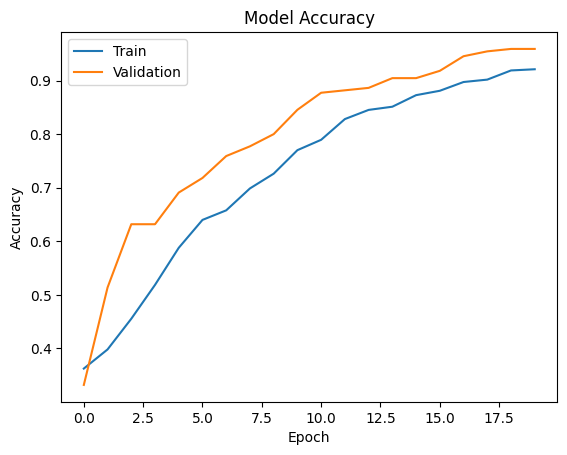

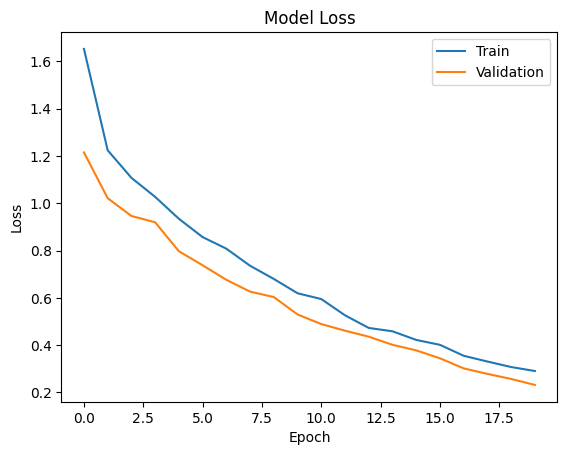

In [ ]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()
# Plot training and validation loss
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

**RNN Model**

In [ ]:
# Assume X_train_smote and X_valid are your image datasets after SMOTE and splitting
n_samples, img_size, img_size, n_channels = X_train_smote.shape
# Reshape the data to fit RNN input shape: (samples, timesteps, features)
X_train_rnn = X_train_smote.reshape(n_samples, img_size, img_size * n_channels)
X_valid_rnn = X_valid.reshape(X_valid.shape[0], img_size, img_size * n_channels)
# Define the RNN model
rnn_model = Sequential()
# Adding RNN layers (you can use LSTM, GRU, or SimpleRNN)
rnn_model.add(LSTM(128, input_shape=(img_size, img_size * n_channels), return_sequences=True))
rnn_model.add(Dropout(0.3))
rnn_model.add(LSTM(64, return_sequences=False))
rnn_model.add(Dropout(0.3))
# Fully connected layer and output layer
rnn_model.add(Dense(64, activation='relu'))
rnn_model.add(Dropout(0.3))
rnn_model.add(Dense(10, activation='softmax'))  # Adjust output size for your specific problem
# Compile the model
rnn_model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='sparse_categorical_crossentropy',  # Assuming integer labels
                  metrics=['accuracy'])
# Print the model summary
rnn_model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 256, 128)            │         197,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_23 (Dropout)                 │ (None, 256, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_24 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_42 (Dense)                     │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_25 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_43 (Dense)                     │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 251,338 (981.79 KB)

 Trainable params: 251,338 (981.79 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = rnn_model.fit(X_train_rnn, y_train_smote,
                        batch_size=32,
                        epochs=30,
                        validation_data=(X_valid_rnn, y_valid),
                        shuffle=True)

Epoch 1/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - accuracy: 0.3161 - loss: 1.6326 - val_accuracy: 0.5227 - val_loss: 1.0197
Epoch 2/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.3510 - loss: 1.2303 - val_accuracy: 0.2682 - val_loss: 1.1067
Epoch 3/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.3605 - loss: 1.1634 - val_accuracy: 0.5500 - val_loss: 1.0806
Epoch 4/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.4303 - loss: 1.0928 - val_accuracy: 0.2591 - val_loss: 1.0353
Epoch 5/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.4195 - loss: 1.0789 - val_accuracy: 0.5727 - val_loss: 0.9792
Epoch 6/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.4267 - loss: 1.0721 - val_accuracy: 0.5773 - val_loss: 0.9905
Epoch 7/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.4417 - loss: 1.0264 - val_accuracy: 0.5955 - val_loss: 0.9854
Epoch 8/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.4549 - loss: 0.9976 - val_accuracy: 0.6000 - v

**Results of RNN Model**

In [ ]:
# Make predictions on the validation set
y_predictions = rnn_model.predict(X_valid_rnn, verbose=1)
# Convert predictions to class labels
y_pred_classes = np.argmax(y_predictions, axis=1)
# Print the classification report
print(classification_report(y_valid, y_pred_classes))
# Print the confusion matrix
print(confusion_matrix(y_true=y_valid, y_pred=y_pred_classes))

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
              precision    recall  f1-score   support

           0       0.30      0.62      0.41        24
           1       0.80      0.89      0.84       113
           2       0.93      0.48      0.63        83

    accuracy                           0.71       220
   macro avg       0.68      0.67      0.63       220
weighted avg       0.79      0.71      0.72       220

[[ 15   9   0]
 [  9 101   3]
 [ 26  17  40]]


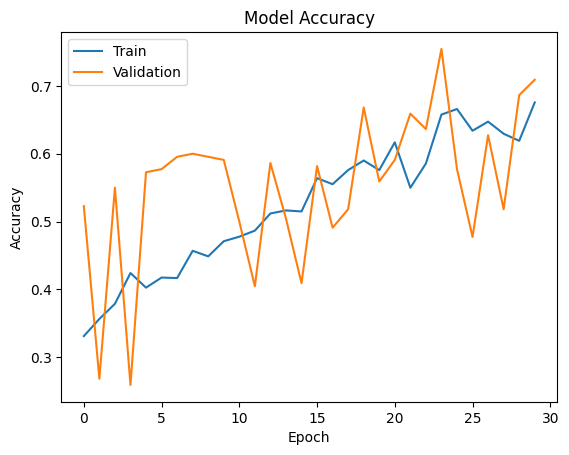

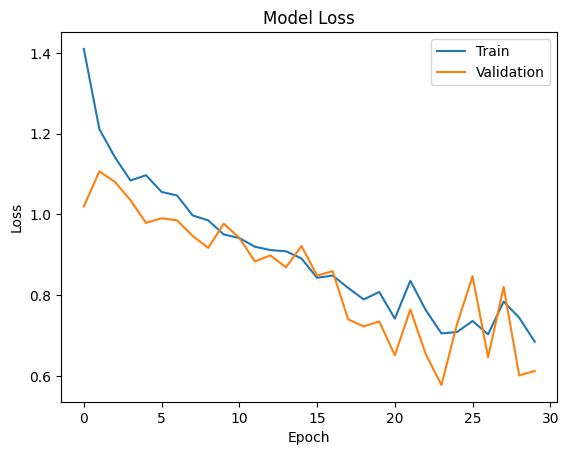

In [ ]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()
# Plot training and validation loss
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

**Auto Encoder Model**

In [ ]:
# Normalize the data
X_train = X_train_smote.astype('float32') / 255.0
X_valid = X_valid.astype('float32') / 255.0
# Flatten the images for the autoencoder input (if using a fully connected autoencoder)
n_samples, img_size, _, n_channels = X_train.shape
X_train_flat = X_train.reshape(n_samples, img_size * img_size * n_channels)
X_valid_flat = X_valid.reshape(X_valid.shape[0], img_size * img_size * n_channels)


In [ ]:
# Define the size of the encoded representation
encoding_dim = 128  # You can adjust this size

# Encoder
input_img = Input(shape=(img_size * img_size * n_channels,))
encoded = Dense(encoding_dim, activation='relu')(input_img)

# Decoder
decoded = Dense(img_size * img_size * n_channels, activation='sigmoid')(encoded)

# Autoencoder model
autoencoder = Model(input_img, decoded)

# Encoder model (for extracting features)
encoder = Model(input_img, encoded)

# Decoder model (for reconstructing data)
encoded_input = Input(shape=(encoding_dim,))
decoder_layer = autoencoder.layers[-1]
decoder = Model(encoded_input, decoder_layer(encoded_input))

# Compile the autoencoder
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

# Print model summary
autoencoder.summary()


Model: "functional_229"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_18 (InputLayer)          │ (None, 65536)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_44 (Dense)                     │ (None, 128)                 │       8,388,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_45 (Dense)                     │ (None, 65536)               │       8,454,144 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,842,880 (64.25 MB)

 Trainable params: 16,842,880 (64.25 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train the autoencoder
history = autoencoder.fit(X_train_flat, X_train_flat,
                          epochs=30,
                          batch_size=256,
                          shuffle=True,
                          validation_data=(X_valid_flat, X_valid_flat))

Epoch 1/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 266ms/step - loss: 0.6926 - val_loss: 0.6907
Epoch 2/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - loss: 0.6900 - val_loss: 0.6861
Epoch 3/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step - loss: 0.6828 - val_loss: 0.6581
Epoch 4/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step - loss: 0.6393 - val_loss: 0.5356
Epoch 5/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step - loss: 0.4883 - val_loss: 0.2923
Epoch 6/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - loss: 0.2418 - val_loss: 0.0912
Epoch 7/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - loss: 0.0725 - val_loss: 0.0263
Epoch 8/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - loss: 0.0228 - val_loss: 0.0144
Epoch 9/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 0.0137 - val_loss: 0.0126
Epoch 10/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - loss: 0.0123 - val_loss: 0.0125
Epoch 11/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - loss: 0.0123 - val_loss: 0.0126
Epoch 12/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - loss: 0.0124 - val_loss:

In [ ]:
# Get the reconstructed images
reconstructed = autoencoder.predict(X_valid_flat)
# Compute the reconstruction loss
from sklearn.metrics import mean_squared_error
# Flatten the reconstructed images
reconstructed_flat = reconstructed.reshape(X_valid_flat.shape)
# Compute the MSE
mse = mean_squared_error(X_valid_flat, reconstructed_flat)
print(f'Mean Squared Error: {mse:.4f}')

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step
Mean Squared Error: 0.0000


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


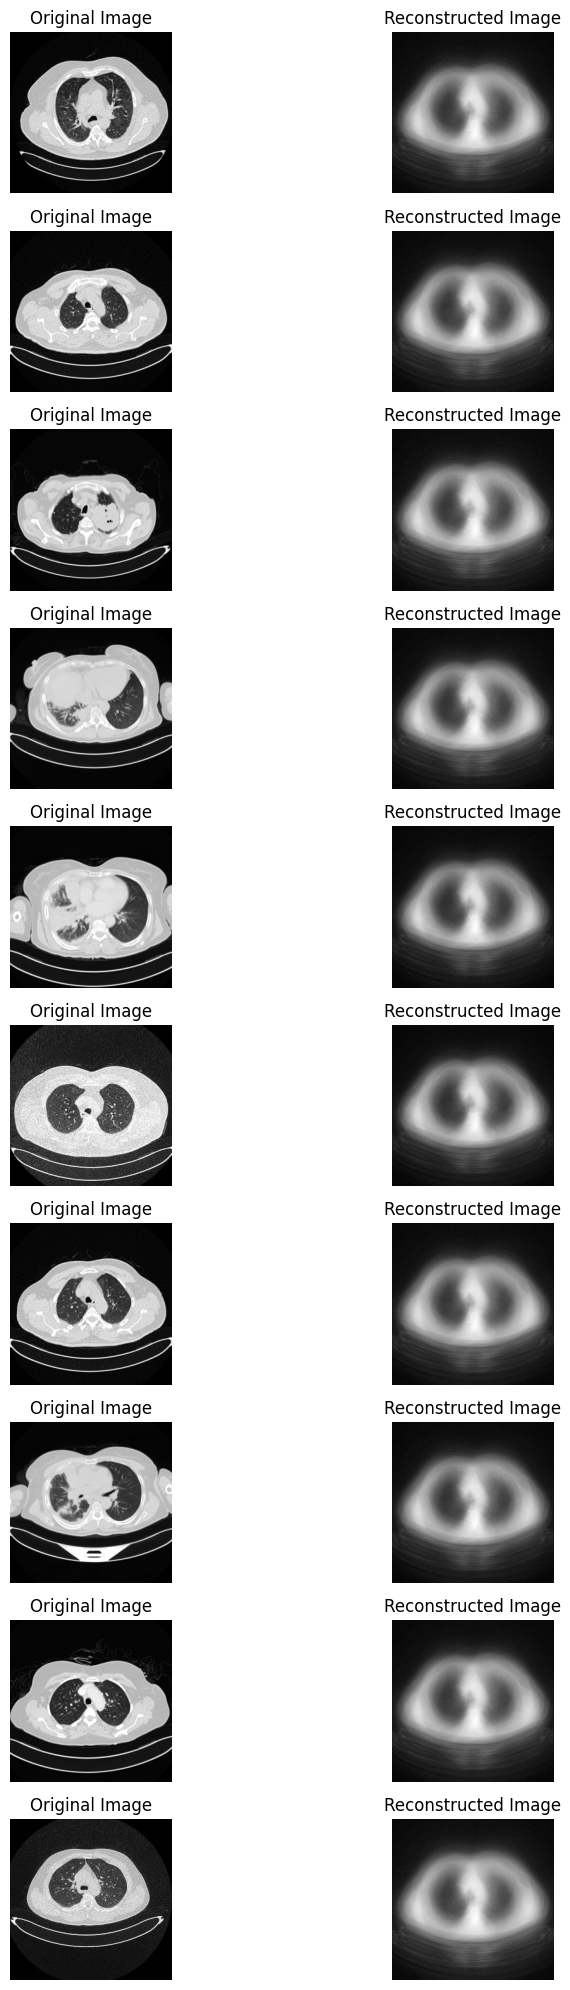

In [ ]:
# Number of images to display
num_images = 10
# Select random indices for images
indices = np.random.choice(range(X_valid.shape[0]), num_images, replace=False)
# Get original and reconstructed images
original_images = X_valid[indices]
reconstructed_images = autoencoder.predict(X_valid_flat[indices])
# Reshape images back to their original shape
original_images = original_images.reshape(num_images, img_size, img_size, n_channels)
reconstructed_images = reconstructed_images.reshape(num_images, img_size, img_size, n_channels)
# Plot original and reconstructed images
fig, axs = plt.subplots(num_images, 2, figsize=(10, 20))
for i in range(num_images):
    # Plot original images
    axs[i, 0].imshow(original_images[i].squeeze(), cmap='gray')
    axs[i, 0].set_title('Original Image')
    axs[i, 0].axis('off')
    # Plot reconstructed images
    axs[i, 1].imshow(reconstructed_images[i].squeeze(), cmap='gray')
    axs[i, 1].set_title('Reconstructed Image')
    axs[i, 1].axis('off')
plt.tight_layout()
plt.show()

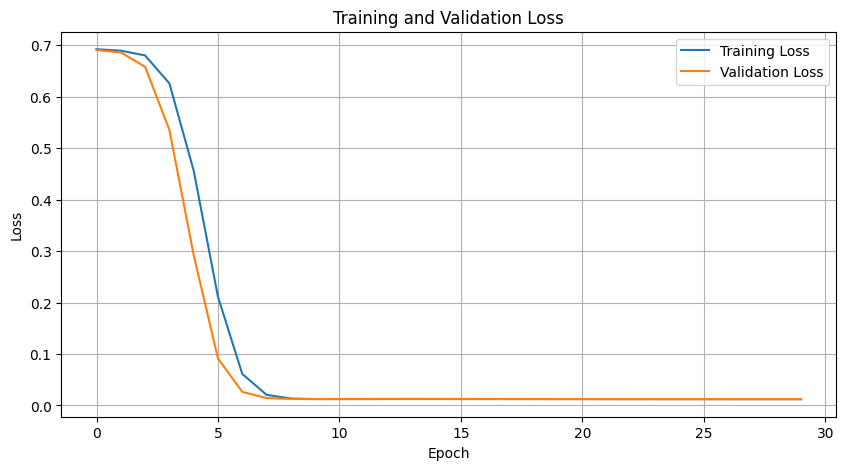

In [ ]:
# Extract loss values from history
train_loss = history.history['loss']
val_loss = history.history['val_loss']
# Plot loss
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()